In [43]:
# 1.目的
# 直近タイム指数について、過去何回分の平均値が適切なのか調べたい
# 2.やったこと
# XGBoostを使う。目的変数を着番とし、説明変数を直近タイム指数（平均1回～5回）とする。それぞれの変数重要度を計算する
# 3.結果
# 以下の通り、直近過去2回の平均が最も重要度が高いことがわかった
#    Feature                                    Importance
# 1  time_index_average_1（直近過去2回の平均）    0.415292
# 0  time_index_average_0（直近過去1回）          0.213166
# 2  time_index_average_2（直近過去3回の平均）    0.133103
# 3  time_index_average_3（直近過去4回の平均）    0.126591
# 4  time_index_average_4（直近過去5回の平均）    0.111848

In [27]:
# インポート
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score

In [29]:
# CSVファイルの読み込み
df = pd.read_csv('input.csv', encoding='cp932')
# df = pd.read_csv('input.csv', encoding='utf-8')

In [ ]:
# 回帰の場合→XGBRegressorを使う

In [35]:
# 説明変数
x = df[["time_index_average_0",
        "time_index_average_1",
        "time_index_average_2",
        "time_index_average_3",
        "time_index_average_4"
#        "jockey_place_rate_5",
#        "jockey_place_rate_6",
#        "jockey_place_rate_7",
#        "jockey_place_rate_8",
#        "jockey_place_rate_9",
#        "conditional_place_rate_10"
       ]]
# 目的変数
y = df["finish_rank"]
# 学習データと検証データの分割（検証データ割合が0.488）
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.488, shuffle=False)

# 欠損値確認
print("NaN の数:", y_train.isna().sum())
print("inf の数:", np.isinf(y_train).sum())
print("異常に大きい値の数（> 1e6）:", (y_train > 1e6).sum())
print("y_train の最大値:", y_train.max())
print("y_train のデータ型:", y_train.dtype)

# モデルの学習
model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=3, random_state=42)
model.fit(x_train, y_train)
# 予測
y_pred = model.predict(x_test)
# 評価
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

NaN の数: 0
inf の数: 0
異常に大きい値の数（> 1e6）: 0
y_train の最大値: 8
y_train のデータ型: int64
RMSE: 2.1839
R^2 Score: 0.0671


In [59]:
# 分類の場合→XGBClassifierを使う

In [61]:
# 説明変数
x = df[["差_直近タイム指数平均1_レース平均値", "騎手複勝率", "条件複勝率2", "条件複勝率4"]]
# 目的変数（文字列のまま扱えないのでラベルエンコーディングする）
le = LabelEncoder()
y = le.fit_transform(df['着番カテゴリ'])
# 学習データと検証データの分割（検証データ割合が0.488）
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.488, shuffle=False)
# モデルの学習
model = xgb.XGBClassifier(objective='reg:squarederror', max_depth=3, random_state=42)
model.fit(x_train, y_train)
# 予測
y_pred = model.predict(x_test)
# 評価
print(f"正解率（Accuracy）: {accuracy_score(y_test, y_pred):.4f}")
print(f"適合率（Precision）: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"再現率（Recall）: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1スコア          : {f1_score(y_test, y_pred, average='weighted'):.4f}")

正解率（Accuracy）: 0.6481
適合率（Precision）: 0.5983
再現率（Recall）: 0.6481
F1スコア          : 0.6047


In [7]:
# 説明変数の重要度を示す

                Feature  Importance
1  time_index_average_1    0.415292
0  time_index_average_0    0.213166
2  time_index_average_2    0.133103
3  time_index_average_3    0.126591
4  time_index_average_4    0.111848


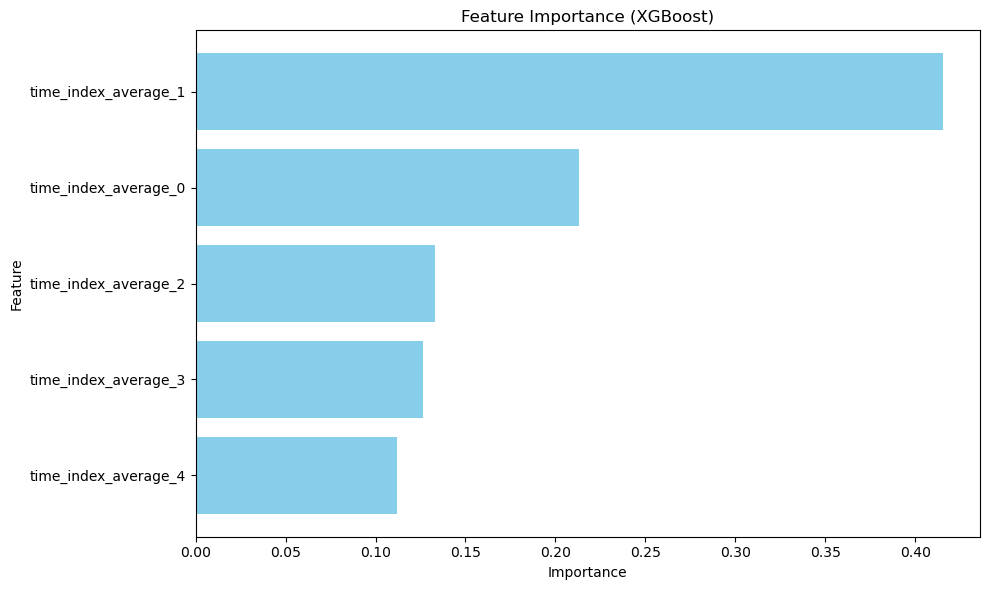

In [37]:
import matplotlib.pyplot as plt

# 特徴量名と重要度を取得
feature_importances = model.feature_importances_
feature_names = x.columns

# DataFrameで整形して、重要度順にソート
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 結果を表示（数値）
print(importances_df)

# 可視化（棒グラフ）
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # 重要度が高いものを上に
plt.tight_layout()
plt.show()